# TD Deep Q-Network

# Tutorial - Deep Q-Learning 

Deep Q-Learning uses a neural network to approximate $Q$ functions. Hence, we usually refer to this algorithm as DQN (for *deep Q network*).

The parameters of the neural network are denoted by $\theta$. 
*   As input, the network takes a state $s$,
*   As output, the network returns $Q_\theta [a | s] = Q_\theta (s,a) = Q(s, a, \theta)$, the value of each action $a$ in state $s$, according to the parameters $\theta$.


The goal of Deep Q-Learning is to learn the parameters $\theta$ so that $Q(s, a, \theta)$ approximates well the optimal $Q$-function $Q^*(s, a) \simeq Q_{\theta^*} (s,a)$. 

In addition to the network with parameters $\theta$, the algorithm keeps another network with the same architecture and parameters $\theta^-$, called **target network**.

The algorithm works as follows:

1.   At each time $t$, the agent is in state $s_t$ and has observed the transitions $(s_i, a_i, r_i, s_i')_{i=1}^{t-1}$, which are stored in a **replay buffer**.

2.  Choose action $a_t = \arg\max_a Q_\theta(s_t, a)$ with probability $1-\varepsilon_t$, and $a_t$=random action with probability $\varepsilon_t$. 

3. Take action $a_t$, observe reward $r_t$ and next state $s_t'$.

4. Add transition $(s_t, a_t, r_t, s_t')$ to the **replay buffer**.

4.  Sample a minibatch $\mathcal{B}$ containing $B$ transitions from the replay buffer. Using this minibatch, we define the loss:

$$
L(\theta) = \sum_{(s_i, a_i, r_i, s_i') \in \mathcal{B}}
\left[
Q(s_i, a_i, \theta) -  y_i
\right]^2
$$
where the $y_i$ are the **targets** computed with the **target network** $\theta^-$:

$$
y_i = r_i + \gamma \max_{a'} Q(s_i', a', \theta^-).
$$

5. Update the parameters $\theta$ to minimize the loss, e.g., with gradient descent (**keeping $\theta^-$ fixed**): 
$$
\theta \gets \theta - \eta \nabla_\theta L(\theta)
$$
where $\eta$ is the optimization learning rate. 

6. Every $N$ transitions ($t\mod N$ = 0), update target parameters: $\theta^- \gets \theta$.

7. $t \gets t+1$. Stop if $t = T$, otherwise go to step 2.

In [1]:
# Imports
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from copy import deepcopy
#!pip install gym shortprint  pyglet --quiet
import gym
from gym.wrappers import Monitor
# from shortprint import shortprint
# TODO: remove shortprint
# from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import clear_output
from pathlib import Path
import base64

#sns.set_palette('brg')  

In [2]:
print(f"python --version = {sys.version}")
print(f"torch.__version__ = {torch.__version__}")
print(f"np.__version__ = {np.__version__}")
print(f"gym.__version__ = {gym.__version__}")

python --version = 3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)]
torch.__version__ = 1.10.2+cu102
np.__version__ = 1.21.5
gym.__version__ = 0.21.0


## Torch 101

>"The torch package contains data structures for multi-dimensional tensors and defines mathematical operations over these tensors. Additionally, it provides many utilities for efficient serializing of Tensors and arbitrary types, and other useful utilities. 
[...] provides classes and functions implementing automatic differentiation of arbitrary scalar valued functions." 
[PyTorch](https://pytorch.org/docs/stable/index.html)


### Variable types

In [3]:
# Very similar syntax to numpy.
zero_torch = torch.zeros((3, 2))

print('zero_torch is of type {:s}'.format(str(type(zero_torch))))

# Torch -> Numpy: simply call the numpy() method.
zero_np = np.zeros((3, 2))
assert (zero_torch.numpy() == zero_np).all()

# Numpy -> Torch: simply call the corresponding function on the np.array.
zero_torch_float = torch.FloatTensor(zero_np)
print('\nFloat:\n', zero_torch_float)
zero_torch_int = torch.LongTensor(zero_np)
print('Int:\n', zero_torch_int)
zero_torch_bool = torch.BoolTensor(zero_np)
print('Bool:\n', zero_torch_bool)

# Reshape
print('\nView new shape...', zero_torch.view(1, 6))
# Note that print(zero_torch.reshape(1, 6)) would work too.
# The difference is in how memory is handled (view imposes contiguity).

# Algebra
a = torch.randn((3, 2))
b = torch.randn((3, 2))
print('\nAlgebraic operations are overloaded:\n', a, '\n+\n', b, '\n=\n', a+b )

# More generally, torch shares the syntax of many attributes and functions with Numpy.

zero_torch is of type <class 'torch.Tensor'>

Float:
 tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])
Int:
 tensor([[0, 0],
        [0, 0],
        [0, 0]])
Bool:
 tensor([[False, False],
        [False, False],
        [False, False]])

View new shape... tensor([[0., 0., 0., 0., 0., 0.]])

Algebraic operations are overloaded:
 tensor([[ 2.3508,  1.0089],
        [-0.6278,  0.7568],
        [-1.0158, -1.4730]]) 
+
 tensor([[-1.2404,  0.2444],
        [ 2.2035, -1.5734],
        [ 1.1796, -0.1281]]) 
=
 tensor([[ 1.1104,  1.2533],
        [ 1.5756, -0.8166],
        [ 0.1639, -1.6011]])


### Gradient management

In [4]:
# torch.Tensor is a similar yet more complicated data structure than np.array.
# It is basically a static array of number but may also contain an overlay to 
# handle automatic differentiation (i.e keeping track of the gradient and which 
# tensors depend on which).
# To access the static array embedded in a tensor, simply call the detach() method
print(zero_torch.detach())

# When inside a function performing automatic differentiation (basically when training 
# a neural network), never use detach() otherwise meta information regarding gradients
# will be lost, effectively freezing the variable and preventing backprop for it. 
# However when returning the result of training, do use detach() to save memory 
# (the naked tensor data uses much less memory than the full-blown tensor with gradient
# management, and is much less prone to mistake such as bad copy and memory leak).

# We will solve theta * x = y in theta for x=1 and y=2
x = torch.ones(1)
y = 2 * torch.ones(1)

# Actually by default torch does not add the gradient management overlay
# when declaring tensors like this. To force it, add requires_grad=True.
theta = torch.randn(1, requires_grad=True)

# Optimisation routine
# (Adam is a sophisticated variant of SGD, with adaptive step).
optimizer = optim.Adam(params=[theta], lr=0.1)

# Loss function
print('Initial guess:', theta.detach())

for _ in range(100):
    # By default, torch accumulates gradients in memory.
    # To obtain the desired gradient descent beahviour,
    # just clean the cached gradients using the following line:
    optimizer.zero_grad()
    
    # Quadratic loss (* and ** are overloaded so that torch
    # knows how to differentiate them)
    loss = (y - theta * x) ** 2
    
    # Apply the chain rule to automatically compute gradients
    # for all relevant tensors.
    loss.backward()
    
    # Run one step of optimisation routine.
    optimizer.step()
    
print('Final estimate:', theta.detach())
print('The final estimate should be close to', y)

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])
Initial guess: tensor([1.3378])
Final estimate: tensor([1.9995])
The final estimate should be close to tensor([2.])


## Setting the environment

### 1 - Define the GLOBAL parameters

In [5]:
# Environment
env = gym.make("CartPole-v0")

# Discount factor
GAMMA = 0.99

# Batch size
BATCH_SIZE = 256
# Capacity of the replay buffer
BUFFER_CAPACITY = 16384 # 10000
# Update target net every ... episodes
UPDATE_TARGET_EVERY = 5 # 20

# Initial value of epsilon
EPSILON_START = 1.0
# Parameter to decrease epsilon
DECREASE_EPSILON = 200
# Minimum value of epislon
EPSILON_MIN = 0.05

# Number of training episodes
N_EPISODES = 400

# Learning rate
LEARNING_RATE = 0.05

### 2 - Replay buffer

In [6]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, reward, next_state):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, reward, next_state)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.choices(self.memory, k=batch_size)

    def __len__(self):
        return len(self.memory)

# create instance of replay buffer
replay_buffer = ReplayBuffer(BUFFER_CAPACITY)

### 3 - Neural Network

In [7]:
class Net(nn.Module):
    """
    Basic neural net.
    """
    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x):
        return self.net(x)

### 3.5 - Loss function and optimizer

In [8]:
# create network and target network
device = torch.device("cpu")

hidden_size = 128
obs_size = env.observation_space.shape[0]
n_actions = env.action_space.n

q_net = Net(obs_size, hidden_size, n_actions).to(device)
target_net = Net(obs_size, hidden_size, n_actions).to(device)

# objective and optimizer
objective = nn.MSELoss()
optimizer = optim.Adam(params=q_net.parameters(), lr=LEARNING_RATE)

In [9]:
def reset():
    """Reset the model and all."""
    global q_net, target_net, replay_buffer, optimizer
    q_net = Net(obs_size, hidden_size, n_actions).to(device)
    target_net = Net(obs_size, hidden_size, n_actions).to(device)
    replay_buffer = ReplayBuffer(BUFFER_CAPACITY)
    optimizer = optim.Adam(params=q_net.parameters(), lr=LEARNING_RATE)
    torch.manual_seed(666)
    np.random.seed(666)
reset()

### Question 0 (to do at home, not during the live session)

With your own word, explain the intuition behind DQN. Recall the main parts of the aformentionned algorithm.

DQN is basically the same as Q learning, the only thing that changes is the fact that Q is not anymore a table of values, but a neural network. This can be very practical when we have a problem with a huge number of states/actions or even infinite (with continuous values). For instance, in this problem of the pole cart, the state is represented by 4 physical values (positions and velocity). Those variables are of course continuous values (bounded by the space of the experiment for the positions).

Therefore, we need to transform this "table of values" by a neural network (or any other machine learning model that can take in continuous values in fact) (if we do not want to discretize the values of course).

The only painpoint of those QDN is that we need to change the way we update the values of Q. Instead of assigning the values, we want to make them change smoothly towards a maximum. Apart from that, it is not that different from the base Q learning

## Implementing the DQN

In [10]:
sample_states = [[0. for i in range(obs_size)] for _ in range(4)]
def get_q(states):
    """
    Compute Q function for a list of states
    """
    with torch.no_grad():
        states_v = torch.FloatTensor(np.array([states])).to(device)
        output = q_net.forward(states_v).detach().cpu().numpy()  # shape (1, len(states), n_actions)
    return output[0, :, :]  # shape (len(states), n_actions)
get_q(sample_states)

array([[0.05859176, 0.21791017],
       [0.05859176, 0.21791017],
       [0.05859176, 0.21791017],
       [0.05859176, 0.21791017]], dtype=float32)

#### Question 1

Implement the `choose_action` function.

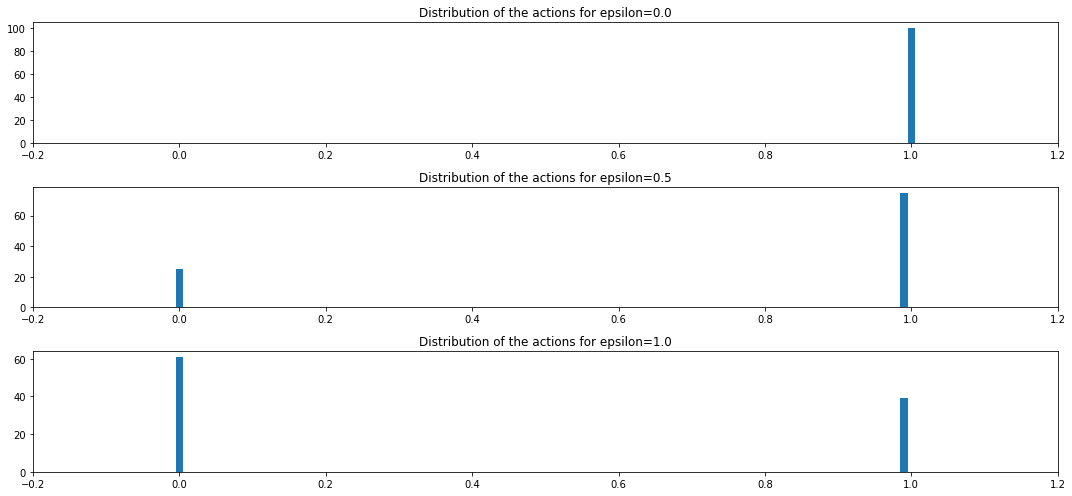

In [11]:
def choose_action(state, epsilon):
    """
    ** TO BE IMPLEMENTED **
    
    Return action according to an epsilon-greedy exploration policy
    """
    if random.random() < 1-epsilon:
        return get_q([state])[0].argmax()
    return random.choice(list(range(n_actions)))

epsilon_values = [0., 0.5, 1.]
fig, axes = plt.subplots(len(epsilon_values), 1, figsize=(15, 7))
for ax, epsilon in zip(axes, epsilon_values):
    actions = []
    for _ in range(100):
        actions.append(choose_action(sample_states[0], epsilon))
    ax.hist(actions, align="left", bins=100);
    ax.set_title(f"Distribution of the actions for {epsilon=}")
    ax.set_xlim(-0.2, 1.2)
plt.tight_layout()

#### Question 2

Implement the `eval_dqn` function.

In [12]:
def eval_dqn(n_sim=5):
    """
    ** TO BE IMPLEMENTED **
    
    Monte Carlo evaluation of DQN agent.

    Repeat n_sim times:
        * Run the DQN policy until the environment reaches a terminal state (= one episode)
        * Compute the sum of rewards in this episode
        * Store the sum of rewards in the episode_rewards array.
    """
    env_copy = deepcopy(env)
    episode_rewards = np.zeros(n_sim)
    for episode_id in range(n_sim):
        observation = env_copy.reset()
        done = False
        while not done:
            observation, reward, done, _ = env_copy.step(choose_action(state=observation, epsilon=0.))
            episode_rewards[episode_id] += reward
    return episode_rewards
N = 10
eval_result = eval_dqn(N)
assert eval_dqn(N).shape == (N,)
#assert np.mean(eval_result)<20
print(eval_result)


[ 9.  9.  9. 10. 10.  9. 10. 11. 10.  8.]


#### Question 3

Implement the `update` function

In [13]:
def update(state, action, reward, next_state, done, verbose=False):
    """
    ** TO BE COMPLETED **
    """
    
    # add data to replay buffer
    if done:
        next_state = None
    replay_buffer.push(state, action, reward, next_state)
    
    if len(replay_buffer) < BATCH_SIZE:
        return np.inf
    
    # get batch
    transitions = replay_buffer.sample(BATCH_SIZE)  # BATCH_SIZE * line (state, action, reward, next_state)

    states = [x[0] for x in transitions]
    actions = [x[1] for x in transitions]
    rewards = [x[2] for x in transitions]
    next_states = [x[3] for x in transitions if isinstance(x[3], np.ndarray)]

    next_states_mask = [isinstance(x[3], np.ndarray) for x in transitions] 
    #print("states", states)


    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions).view(-1, 1)
    rewards = torch.FloatTensor(rewards).view(-1, 1)
    next_states = torch.FloatTensor(next_states)
    mask = torch.BoolTensor(next_states_mask)

    # Compute loss - TO BE IMPLEMENTED!

    values  = q_net(states.to(device)).cpu() # Shape (nbr_states, nbr_actions)
    values = torch.gather(values, dim=1, index=actions) # We retrieve the Q(s,a) for the selected action a
    if verbose:
        print("Values:", values.shape)

    # Compute the target
    values_next_states = torch.zeros(BATCH_SIZE)
    values_next_states[mask] = target_net(next_states.to(device)).cpu().max(dim=1)[0].detach()

    targets = rewards + GAMMA * values_next_states.view(-1, 1)   # to be computed using batch
    if verbose:
        print("target", targets.shape)
    
    loss = objective(values, targets)
     
    # Optimize the model - UNCOMMENT!
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.detach().numpy()

update(sample_states[0], 0, 1., 1, False)

inf

#### Question 4
Train a DQN on the `env` environment.
*Hint* The mean reward after training should be close to 200.

episode = 3, reward = 8.8, loss = inf
episode = 6, reward = 9.4, loss = inf
episode = 9, reward = 9.8, loss = inf


C:\Users\marco\AppData\Local\Temp/ipykernel_15456/1380838915.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  states = torch.FloatTensor(states)


episode = 12, reward = 82.8, loss = 0.20056432485580444
episode = 15, reward = 9.4, loss = 0.001813430106267333
episode = 18, reward = 9.6, loss = 0.036369841545820236
episode = 21, reward = 9.0, loss = 0.04011768102645874
episode = 24, reward = 9.0, loss = 0.09602297097444534
episode = 27, reward = 9.2, loss = 0.31674179434776306
episode = 30, reward = 9.2, loss = 0.12981389462947845
episode = 33, reward = 9.4, loss = 0.20586204528808594
episode = 36, reward = 9.4, loss = 0.12589524686336517
episode = 39, reward = 11.0, loss = 0.12261293083429337
episode = 42, reward = 59.8, loss = 0.3424122929573059
episode = 45, reward = 64.8, loss = 0.10490325838327408
episode = 48, reward = 158.0, loss = 0.20513038337230682
episode = 51, reward = 138.4, loss = 0.19305436313152313
episode = 54, reward = 48.4, loss = 0.30433520674705505
episode = 57, reward = 62.8, loss = 0.4786870777606964
episode = 60, reward = 74.4, loss = 0.2772926986217499
episode = 63, reward = 68.8, loss = 0.18286778032779694

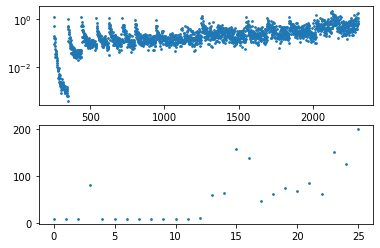

In [14]:
EVAL_EVERY = 3
REWARD_THRESHOLD = 199

def train(verbose: bool = True):
    state = env.reset()
    epsilon = EPSILON_START
    ep = 0
    losses = []
    total_time = 0
    rewards_history = []
    while ep < N_EPISODES:
        action = choose_action(state, epsilon)

        # take action and update replay buffer and networks
        next_state, reward, done, _ = env.step(action)
        loss = update(state, action, reward, next_state, done)
        losses.append(loss)
        # update state
        state = next_state

        # end episode if done
        if done:
            state = env.reset()
            ep   += 1
            if ( (ep+1)% EVAL_EVERY == 0):
                reward = np.mean(eval_dqn())
                rewards_history.append(reward)
                if verbose:
                    print(f"episode = {ep+1}, reward = {reward}, loss = {loss}")
                if reward >= REWARD_THRESHOLD:
                    break

            # update target network
            if ep % UPDATE_TARGET_EVERY == 0:
                target_net.load_state_dict(q_net.state_dict())
            # decrease epsilon
            epsilon = EPSILON_MIN + (EPSILON_START - EPSILON_MIN) * \
                            np.exp(-1. * ep / DECREASE_EPSILON )    
        total_time += 1
    return ep, losses, rewards_history

reset()

# Run the training loop
ep, losses, rewards_history = train()

# Evaluate the final policy
rewards = eval_dqn(20)
print("\nmean reward after training = ", np.mean(rewards))
fig, axes = plt.subplots(2, 1)
axes[0].scatter(list(range(len(losses))), losses, s=3)
axes[0].set_yscale('log')
axes[1].scatter(list(range(len(rewards_history))), rewards_history, s=3);

#### Question 5

Experiment the policy network.

(Showing a video with a jupyter notebook, you may try this cell with Chrome/Chromium instead of Firefox. Otherwise, you may skip this question.)

**You will not be able to see the video online, but I promise you it works, you have my word !**

In [15]:
video_folder = "./videos"
env = Monitor(env, video_folder, force=True, video_callable=lambda episode: True)

for episode in range(1):
    done = False
    state = env.reset()
    while not done:
        action = choose_action(state, 0.0)
        state, reward, done, info = env.step(action)
env.close()

from IPython.display import Video
import os
from glob import glob
Video(glob(os.path.join(video_folder, "*.mp4"))[0])


d:\Documents\centralesupelec\reinforcement_learning\venv\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Impossible de modifier le mode thread une fois qu’il a été fixé
  warnings.warn(str(err))


### Experiments: Do It Yourself

Remember the set of global parameters:
```
# Environment
env = gym.make("CartPole-v0")

# Discount factor
GAMMA = 0.99

# Batch size
BATCH_SIZE = 256
# Capacity of the replay buffer
BUFFER_CAPACITY = 16384 # 10000
# Update target net every ... episodes
UPDATE_TARGET_EVERY = 32 # 20

# Initial value of epsilon
EPSILON_START = 1.0
# Parameter to decrease epsilon
DECREASE_EPSILON = 200
# Minimum value of epislon
EPSILON_MIN = 0.05

# Number of training episodes
N_EPISODES = 200

# Learning rate
LEARNING_RATE = 0.1
```

In [16]:
def run_one():
    """Run once the training and evaluation of the model.
    
    This make sure we restart from zero each times, and retrieve meaningfull informations.
    For the losses and rewards, those are saved respectively at the end of each episode and every 3 episodes
    """
    reset()
    result = {}
    result['episode_takens'], losses, rewards_history = train(verbose=False)
    result['score'] = np.mean(eval_dqn())
    result['losses'] = losses
    result['rewards'] = rewards_history
    return result

#### Question 6: BUFER_CAPACITY

Craft an experiment and study the influence of the `BUFFER_CAPACITY` on the learning process (speed of *convergence*, training curves...) 

In [17]:
# We save the current value in a variable, to avoid problems for the other studies
# we will change it back to the default value after.
# It would have been better to put those values as argument of a function
# But w'll do like that for now
previous_value = BUFFER_CAPACITY


nbr_values = 7
nbr_each = 3  # Due to the randomness of the training, we do it several times for the same set of parameters
results = []
with tqdm(total=nbr_values*nbr_each, desc="Compute the influence", colour="green") as pbar:
    for i in np.linspace(500, 100000, nbr_values):
        BUFFER_CAPACITY = int(i)
        for _ in range(nbr_each):
            results.append({
                "Buffer Capacity": BUFFER_CAPACITY,
                **run_one()
            })

            pbar.update()
df = pd.DataFrame.from_records(results)

BUFFER_CAPACITY = previous_value

Compute the influence: 100%|██████████| 21/21 [02:16<00:00,  6.48s/it]


In [18]:
df.head()

,Buffer Capacity,episode_takens,score,losses,rewards
0,500,113,200.0,"[inf, inf, inf, inf, inf, inf, inf, inf, inf, ...","[9.2, 9.0, 9.2, 9.4, 9.0, 8.8, 9.2, 9.6, 18.6,..."
1,500,113,200.0,"[inf, inf, inf, inf, inf, inf, inf, inf, inf, ...","[9.2, 10.0, 9.8, 9.4, 9.6, 12.8, 9.8, 9.6, 8.8..."
2,500,32,199.6,"[inf, inf, inf, inf, inf, inf, inf, inf, inf, ...","[9.6, 9.6, 10.0, 9.4, 12.2, 10.6, 10.6, 46.8, ..."
3,17083,77,200.0,"[inf, inf, inf, inf, inf, inf, inf, inf, inf, ...","[9.2, 9.0, 9.4, 9.4, 9.2, 9.2, 10.0, 9.8, 48.6..."
4,17083,38,200.0,"[inf, inf, inf, inf, inf, inf, inf, inf, inf, ...","[9.0, 9.2, 9.8, 9.4, 9.4, 9.6, 10.4, 11.0, 112..."


In [19]:
new_df = []
for _, row in df.iterrows():
    x = pd.DataFrame({"losses":row.losses}).reset_index()
    x['buffer'] = str(row['Buffer Capacity'])
    x['losses']=x['losses'].astype(float)
    new_df.append(x)
new_df = pd.concat(new_df, ignore_index=True)
new_df.head(3)

,index,losses,buffer
0,0,inf,500
1,1,inf,500
2,2,inf,500


Text(0.5, 1.0, 'Losses over time for different values of buffer')

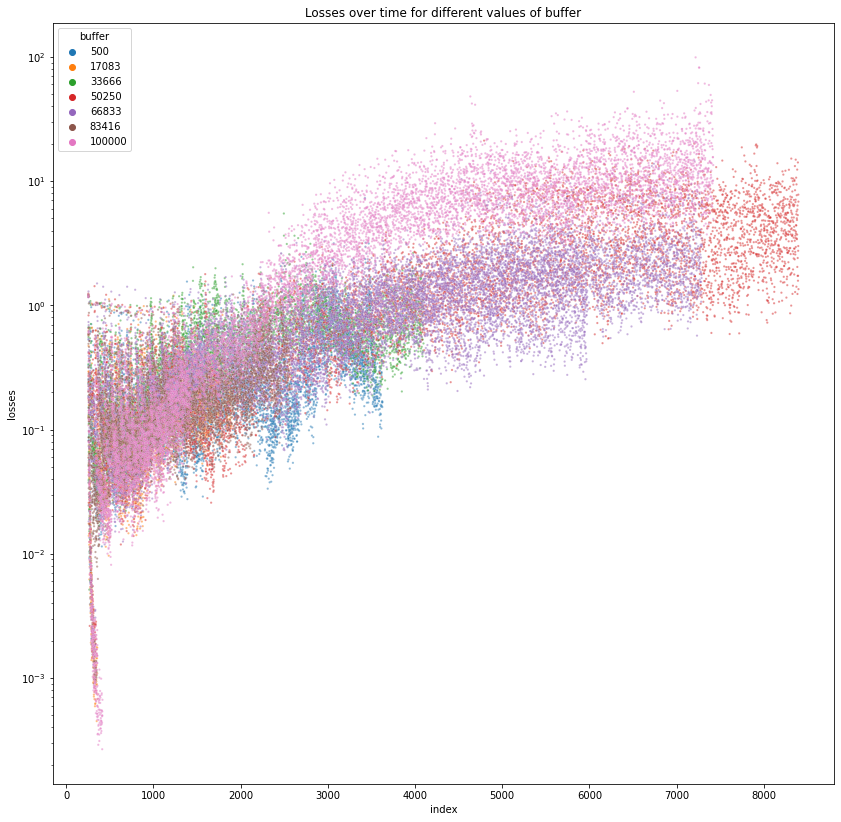

In [20]:
plt.figure(figsize=(14, 14))
sns.scatterplot(data=new_df, x="index", y="losses", hue="buffer", alpha=0.5, s=5)
plt.yscale('log')
plt.title("Losses over time for different values of buffer");

The above graphic shows the loss over time (after each episode / action). We wanted to see if there was an influence over the losses (and so the training of the model).
Even if the final graphic is a bit overwhelmed with points, the values of the loss do not seem to be very different between the different colors (buffer sizes). We can say that the loss is not influenced by the buffer size

In [21]:
new_df = []
for _, row in df.iterrows():
    x = pd.DataFrame({"rewards":row.rewards}).reset_index()
    x['buffer'] = str(row['Buffer Capacity'])
    x['rewards']=x['rewards'].astype(float)
    new_df.append(x)
new_df = pd.concat(new_df, ignore_index=True)
new_df.head(3)


,index,rewards,buffer
0,0,9.2,500
1,1,9.0,500
2,2,9.2,500


Text(0.5, 1.0, 'The evolution of the reward over time depending of the buffer value')

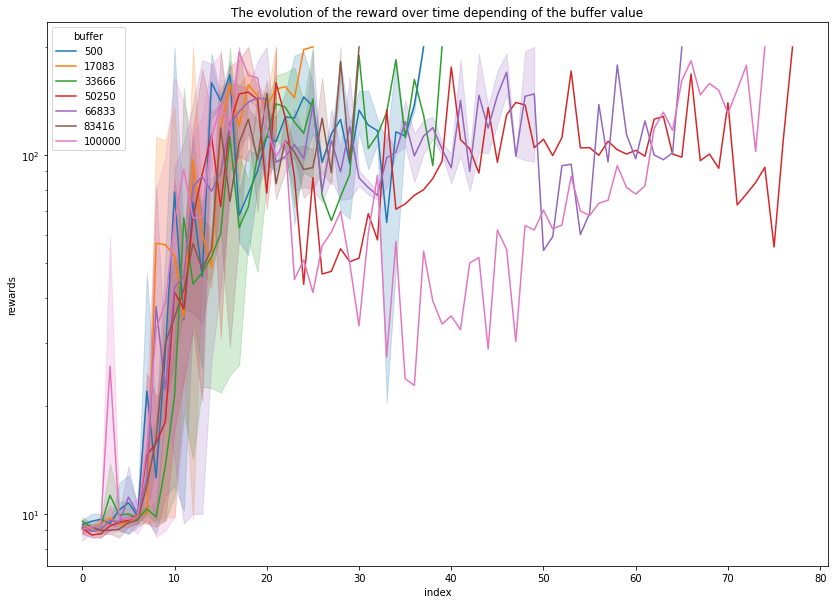

In [22]:
plt.figure(figsize=(14, 10))
sns.lineplot(data=new_df, x="index", y="rewards", hue="buffer")
plt.yscale('log')
plt.title("The evolution of the reward over time depending of the buffer value")

On this graphic, you can see the evolution of the reward over time for the different buffer sizes. Even if the graphic might be a bit biaised by the fact that the batch size is around 256 (and so, the first value is around 500). We can say that very low values of the buffer size (or close to the batch size) might restrain the model training performance, because it will reduce the number of seen actions (and so, learning points). 
If you take a student and give him/her only one lesson, even if he/she is very good, he/she will not be able to learn as much as for a student with dozens of lessons. The same applies for those QDN models.

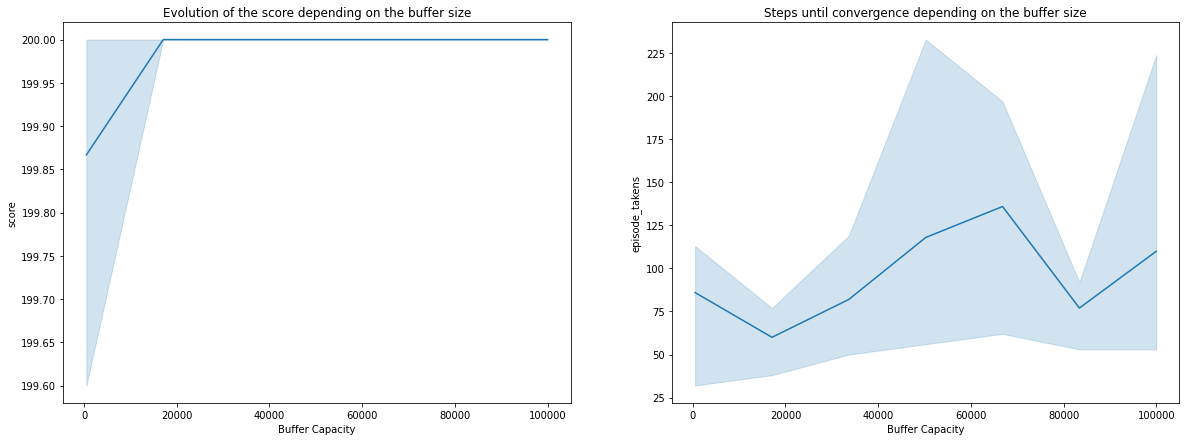

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(20,7))

axes[0].set_title("Evolution of the score depending on the buffer size")
sns.lineplot(x=df['Buffer Capacity'], y=df['score'], ax=axes[0])
axes[1].set_title("Steps until convergence depending on the buffer size")
sns.lineplot(x=df['Buffer Capacity'], y=df['episode_takens'], ax=axes[1]);

This graphic show the "mean score" at the end of the experiment depending on the buffer capacity. We can clearly see on the left one that low values of buffer capacity leads to difficulties to learn the path to a perfect score. 

#### Question 7: UPDATE_TARGET_EVERY

Craft an experiment and study the influence of the `UPDATE_TARGET_EVERY` on the learning process (speed of *convergence*, training curves...) 

In [24]:
previous_value = UPDATE_TARGET_EVERY

nbr_values = 7
nbr_each = 3
results = []
with tqdm(total=nbr_values*nbr_each, desc="Compute the influence", colour="green") as pbar:
    for i in np.linspace(3, 200, nbr_values):
        UPDATE_TARGET_EVERY = int(i)
        for _ in range(nbr_each):
            results.append({
                "Update every value": UPDATE_TARGET_EVERY,
                **run_one()
            })

            pbar.update()
df = pd.DataFrame.from_records(results)

UPDATE_TARGET_EVERY = previous_value

Compute the influence: 100%|██████████| 21/21 [04:00<00:00, 11.44s/it]


In [25]:
df.head()

,Update every value,episode_takens,score,losses,rewards
0,3,110,200.0,"[inf, inf, inf, inf, inf, inf, inf, inf, inf, ...","[9.6, 9.4, 9.2, 9.0, 9.6, 10.4, 12.0, 19.6, 19..."
1,3,47,200.0,"[inf, inf, inf, inf, inf, inf, inf, inf, inf, ...","[9.2, 10.0, 9.8, 9.4, 9.8, 10.2, 9.4, 16.6, 11..."
2,3,35,200.0,"[inf, inf, inf, inf, inf, inf, inf, inf, inf, ...","[8.8, 9.0, 9.0, 9.2, 10.4, 9.4, 10.2, 9.8, 14...."
3,35,248,200.0,"[inf, inf, inf, inf, inf, inf, inf, inf, inf, ...","[9.2, 9.0, 9.4, 9.2, 9.4, 9.0, 10.6, 10.4, 10...."
4,35,206,200.0,"[inf, inf, inf, inf, inf, inf, inf, inf, inf, ...","[9.2, 9.6, 9.6, 8.8, 54.2, 9.4, 11.0, 13.6, 13..."


In [26]:
new_df = []
for _, row in df.iterrows():
    x = pd.DataFrame({"losses":row.losses}).reset_index()
    x['update_every'] = str(row['Update every value'])
    x['losses']=x['losses'].astype(float)
    new_df.append(x)
new_df = pd.concat(new_df, ignore_index=True)
new_df.head(3)

,index,losses,update_every
0,0,inf,3
1,1,inf,3
2,2,inf,3


Text(0.5, 1.0, 'Losses over time for different values of network update frequency')

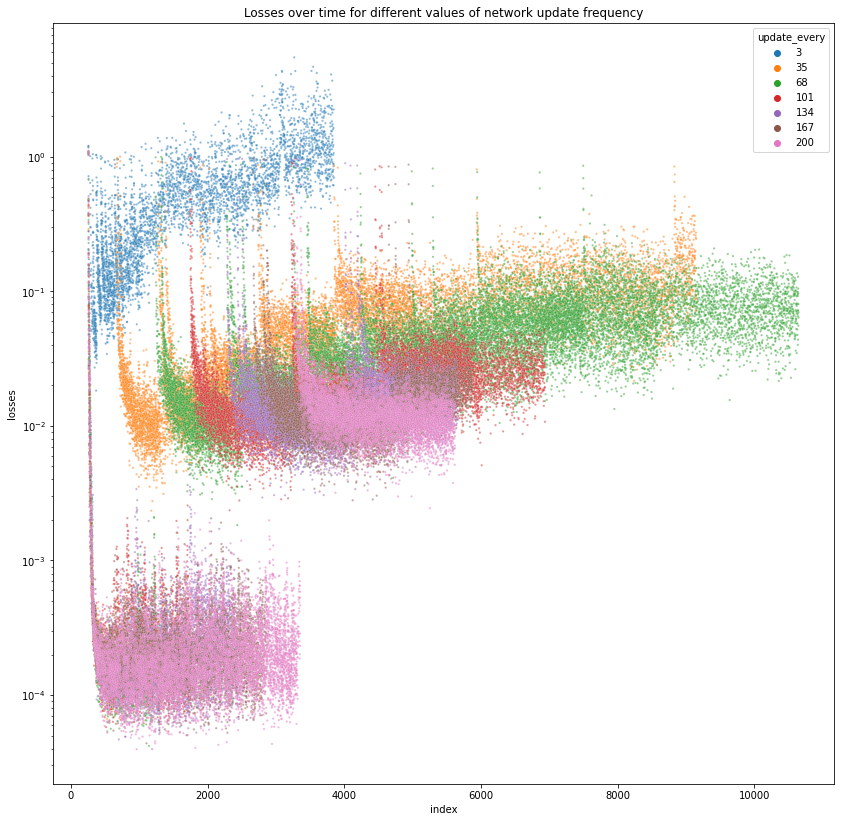

In [27]:
plt.figure(figsize=(14, 14))
sns.scatterplot(data=new_df, x="index", y="losses", hue="update_every", alpha=0.5, s=5)
plt.yscale('log')
plt.title("Losses over time for different values of network update frequency")

In [28]:
new_df = []
for _, row in df.iterrows():
    x = pd.DataFrame({"rewards":row.rewards}).reset_index()
    x['update_every'] = str(row['Update every value'])
    x['rewards']=x['rewards'].astype(float)
    new_df.append(x)
new_df = pd.concat(new_df, ignore_index=True)
new_df.head(3)


,index,rewards,update_every
0,0,9.6,3
1,1,9.4,3
2,2,9.2,3


Text(0.5, 1.0, 'Reward over time for different values of the network update frequency')

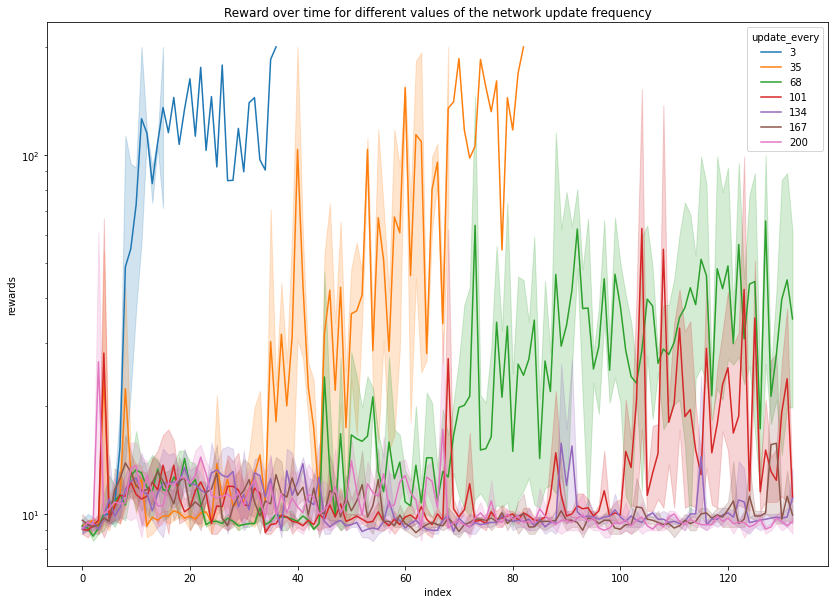

In [29]:
plt.figure(figsize=(14, 10))
sns.lineplot(data=new_df, x="index", y="rewards", hue="update_every")
plt.yscale('log')
plt.title('Reward over time for different values of the network update frequency')

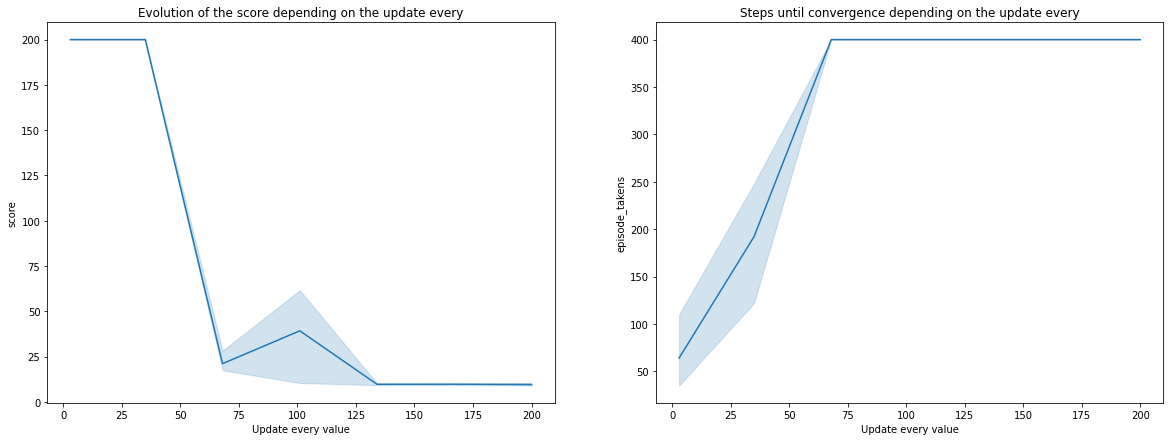

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(20,7))

axes[0].set_title("Evolution of the score depending on the update every")
sns.lineplot(x=df['Update every value'], y=df['score'], ax=axes[0])
axes[1].set_title("Steps until convergence depending on the update every")
sns.lineplot(x=df['Update every value'], y=df['episode_takens'], ax=axes[1]);

In [31]:
previous_value = BATCH_SIZE

nbr_values = 7
nbr_each = 3
results_batch_size = []
with tqdm(total=nbr_values*nbr_each, desc="Compute the influence", colour="green") as pbar:
    for i in np.linspace(10, 1000, nbr_values):
        BATCH_SIZE = int(i)
        for _ in range(nbr_each):
            results_batch_size.append({
                "BATCH_SIZE": BATCH_SIZE,
                **run_one()
            })
            pbar.update()
            
BATCH_SIZE = previous_value

Compute the influence: 100%|██████████| 21/21 [02:23<00:00,  6.81s/it]


In [32]:
df_batch_size = pd.DataFrame.from_records(results_batch_size)

new_df_batch_size = []
for _,row in df_batch_size.iterrows():
    x = pd.DataFrame({'losses' : row.losses}).reset_index()
    x['batch_size'] = str(row['BATCH_SIZE'])
    x['losses']=x['losses'].astype(float)
    new_df_batch_size.append(x)
    
new_df_batch_size = pd.concat(new_df_batch_size, ignore_index=True)
new_df_batch_size.head(3)

,index,losses,batch_size
0,0,inf,10
1,1,inf,10
2,2,inf,10


Text(0.5, 1.0, 'Losses over time for different values of batch_size')

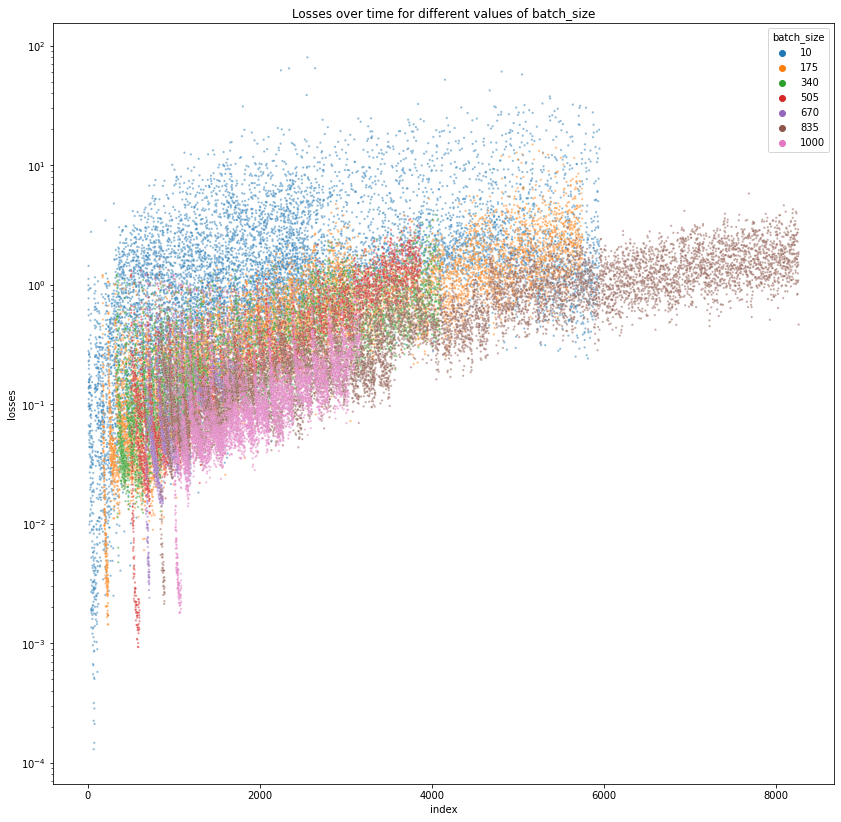

In [33]:
plt.figure(figsize=(14, 14))
sns.scatterplot(data=new_df_batch_size, x="index", y="losses", hue="batch_size", alpha=0.5, s=5)
plt.yscale('log')
plt.title("Losses over time for different values of batch_size")


In [34]:
new_df_batch_size = []
for _, row in df_batch_size.iterrows():
    x = pd.DataFrame({"rewards":row.rewards}).reset_index()
    x['batch_size'] = str(row['BATCH_SIZE'])
    x['rewards']=x['rewards'].astype(float)
    new_df_batch_size.append(x)
new_df_batch_size = pd.concat(new_df_batch_size, ignore_index=True)
new_df_batch_size.head(3)

,index,rewards,batch_size
0,0,9.8,10
1,1,13.0,10
2,2,9.2,10


Text(0.5, 1.0, 'Reward over time for different values of the network update frequency')

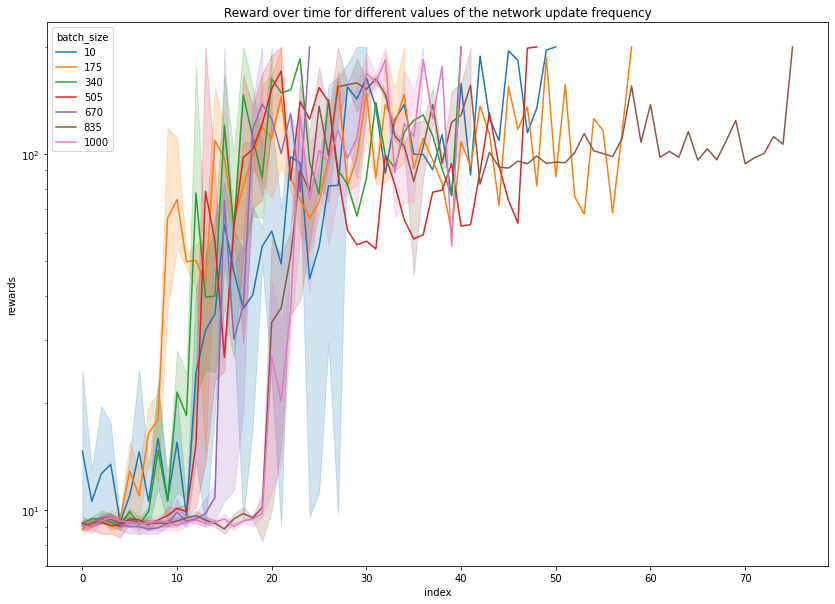

In [35]:
plt.figure(figsize=(14, 10))
sns.lineplot(data=new_df_batch_size, x="index", y="rewards", hue="batch_size")
plt.yscale('log')
plt.title('Reward over time for different values of the network update frequency')

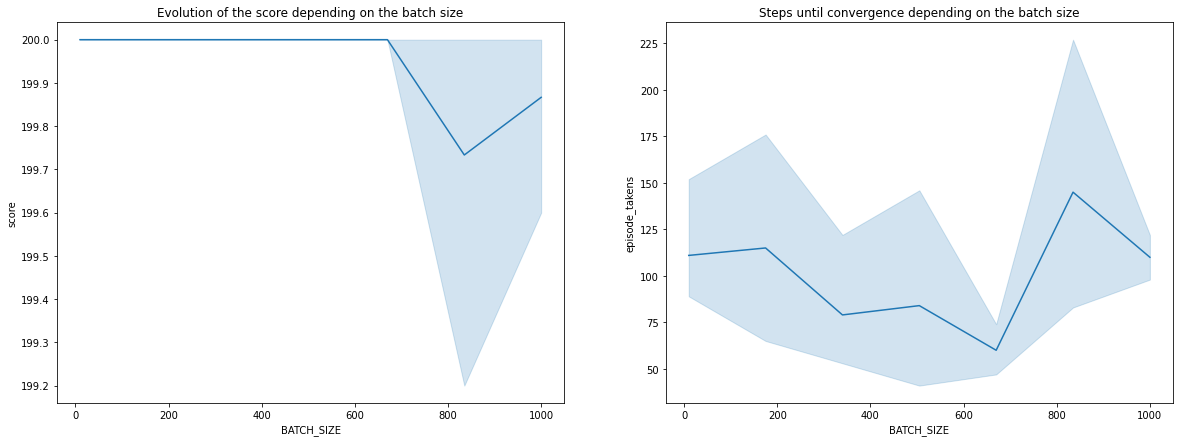

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(20,7))

axes[0].set_title("Evolution of the score depending on the batch size")
sns.lineplot(x=df_batch_size['BATCH_SIZE'], y=df_batch_size['score'], ax=axes[0])
axes[1].set_title("Steps until convergence depending on the batch size")
sns.lineplot(x=df_batch_size['BATCH_SIZE'], y=df_batch_size['episode_takens'], ax=axes[1]);

### Map of the results

    | Num | Observation           | Min                  | Max                |
    |-----|-----------------------|----------------------|--------------------|
    | 0   | Cart Position         | -4.8*                 | 4.8*                |
    | 1   | Cart Velocity         | -Inf                 | Inf                |
    | 2   | Pole Angle            | ~ -0.418 rad (-24°)** | ~ 0.418 rad (24°)** |
    | 3   | Pole Angular Velocity | -Inf                 | Inf                |

In [37]:
OBS_1 = 0
OBS_2 = 1
ACTION_TO_TAKE = 0
OBSERVATIONS = ['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Angular Velocity']

nX = 100
nY = 100

In [38]:
x_name = OBSERVATIONS[OBS_1]
y_name = OBSERVATIONS[OBS_2]

x_values = torch.tensor(
    np.linspace(env.observation_space.low[OBS_1], env.observation_space.high[OBS_1], nX)
)
y_values = torch.tensor(
    np.linspace(env.observation_space.low[OBS_2], env.observation_space.high[OBS_2], nY)
)


In [39]:
import ipywidgets as widgets

In [40]:
obs_3 = widgets.FloatSlider(min=-0.418, max=0.418, step=0.01, value=0.)
obs_3

FloatSlider(value=0.0, max=0.418, min=-0.418, step=0.01)

In [41]:
obs_4 = widgets.FloatSlider(min=-0.418, max=0.418, step=0.01, value=0.)
obs_4

FloatSlider(value=0.0, max=0.418, min=-0.418, step=0.01)

OBS 3: 0.0
OBS 4: 0.0


d:\Documents\centralesupelec\reinforcement_learning\venv\lib\site-packages\matplotlib\colors.py:1254: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)
d:\Documents\centralesupelec\reinforcement_learning\venv\lib\site-packages\matplotlib\colors.py:621: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


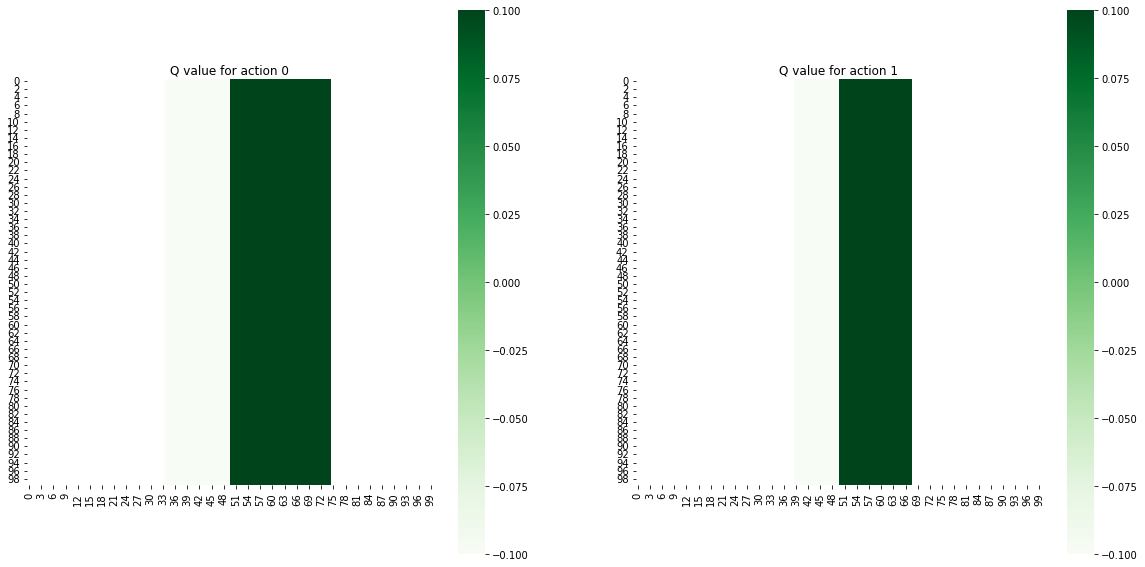

In [42]:
values = torch.zeros((2,nX, nY))
actions_to_take = torch.zeros((nX, nY))
print(f"OBS 3: {obs_3.value}")
print(f"OBS 4: {obs_4.value}")
with torch.no_grad():
    for i,x in enumerate(x_values):
        for j,y in enumerate(y_values):

            q = q_net(torch.FloatTensor([[x, y, obs_3.value, obs_3.value]]))
            values[:,i,j] = q[0]
            actions_to_take[i,j] = q[0].argmax()

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
for action in range(2):
    sns.heatmap(values[action], ax=axes[action] ,cmap="Greens");
    axes[action].set_title(f"Q value for action {action}")
    axes[action].set_aspect('equal', 'box')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


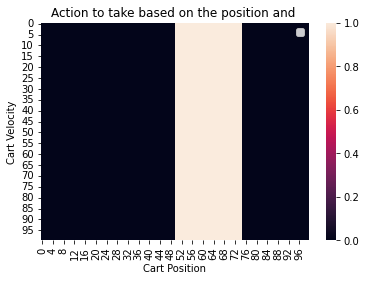

In [43]:
plt.title("Action to take based on the position and ")

sns.heatmap(actions_to_take);
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.legend();

#### Question 8

If you have the computer power to do so, try to do a grid search on those two hyper-parameters and comment the results. Otherwise, study the influence of another hyper-parameter.

## Discretization

It is natural to use a function approximator like a neural network to approximate the $Q$ function in a continuous environment. Another natural but unscalable way to do handle continuous state-action space is **discretization**.

Discretize the environment of your choice (cartpole or mountain car or both) and run one of the algorithms that you know to compute an approximation of the optimal $Q$ function.

### The discretization step is in another notebook, to avoid erasing the previous graphics